In [1]:
!pip install --quiet git+https://github.com/ain3007-project/project-utils.git

In [2]:
import huggingface_hub as hfh
import pandas as pd
from project_utils.preprocessing import process
from project_utils.plotting import plot_image_mask_by_path

In [3]:
hfh.login("INSERT TOKEN HERE")

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [4]:
hfh.utils.disable_progress_bars()

In [5]:
external_test_repo_id = "ain3007-project/raw-external-test-dataset"
internal_test_repo_id = "ain3007-project/raw-internal-test-dataset"

In [6]:
image_size = 512
pad_images = True

output_repo_id = f"ain3007-project/test-dataset-thumbnails-{image_size}"

if pad_images:
    output_repo_id += "-padded"

In [7]:
hfh.create_repo(output_repo_id, private=True, repo_type="dataset", exist_ok=True)

RepoUrl('https://huggingface.co/datasets/ain3007-project/test-dataset-thumbnails-512-padded', endpoint='https://huggingface.co', repo_type='dataset', repo_id='ain3007-project/test-dataset-thumbnails-512-padded')

In [8]:
# get all the filenames
all_files_external = list(hfh.list_files_info(repo_id=external_test_repo_id, repo_type="dataset"))
all_files_internal = list(hfh.list_files_info(repo_id=internal_test_repo_id, repo_type="dataset"))
all_files_external[:5]

[RepoFile(path='.gitattributes', size=5257, blob_id='9408dffb7f14703972c362793536d1d614974372', lfs=None, last_commit=None, security=None),
 RepoFile(path='breast__he__10068.ndpi', size=162377221, blob_id='6998801e706dcfd60bfecaab5fbbfb9e03255cf5', lfs={'size': 162377221, 'sha256': 'a2495145aca18cff0c70e13ae51e571f368873607ca5929eeffc5263edde5021', 'pointer_size': 134}, last_commit=None, security=None),
 RepoFile(path='breast__he__10068.xml', size=180740, blob_id='c6988351db7e295fb9db996b86815c005b068b2b', lfs=None, last_commit=None, security=None),
 RepoFile(path='breast__he__12008.svs', size=431400056, blob_id='d28fdb9fa59fb56327500576026b35235403bec2', lfs={'size': 431400056, 'sha256': 'ee210197ef65486331edf911c17a2f91c6b55cb8a47883ea352a3ca3d135363a', 'pointer_size': 134}, last_commit=None, security=None),
 RepoFile(path='breast__he__12008.xml', size=851663, blob_id='d7208080afb08d83082e1e51289af0a4bddaf13a', lfs=None, last_commit=None, security=None)]

In [9]:
file_names_external = list(map(lambda x: x.rfilename, all_files_external))
file_names_internal = list(map(lambda x: x.rfilename, all_files_internal))
file_names_external[:5]

['.gitattributes',
 'breast__he__10068.ndpi',
 'breast__he__10068.xml',
 'breast__he__12008.svs',
 'breast__he__12008.xml']

In [10]:
file_names_external.remove(".gitattributes")
file_names_internal.remove(".gitattributes")

file_names_external[:5]

['breast__he__10068.ndpi',
 'breast__he__10068.xml',
 'breast__he__12008.svs',
 'breast__he__12008.xml',
 'breast__he__12066.svs']

In [11]:
file_extensions_external = list(set(list(map(lambda x: x.split(".")[-1], file_names_external))))
file_extensions_external

['xml', 'ndpi', 'tiff', 'svs']

In [12]:
file_extensions_internal = filter(lambda x: ("/" not in x), file_names_internal)
file_extensions_internal = list(set(list(map(lambda x: x.split(".")[-1], file_extensions_internal))))
file_extensions_internal

['xml', 'ndpi', 'tif', 'svs', 'tiff', 'mrxs']

In [13]:
file_extensions_external.remove("xml")
file_extensions_internal.remove("xml")

In [14]:
!mkdir -p images masks

In [15]:
def get_allow_list(file_id, file_extension):
    if file_extension == "mrxs":
        return (file_id+"/*", file_id+".*"), file_id+".mrxs", file_id+".xml"
    else:
        return (file_id+"*", file_id+f".{file_extension}", file_id+".xml")

In [16]:
# generate allow patterns for processing
external_file_list = []
for file_extension in file_extensions_external:
    external_unique_ids = [f.replace(f".{file_extension}", "") for f in file_names_external if f.endswith(f".{file_extension}")]
    external_file_list.extend([get_allow_list(file_id, file_extension) for file_id in external_unique_ids])
external_file_list[:5]

[('breast__he__10068*', 'breast__he__10068.ndpi', 'breast__he__10068.xml'),
 ('breast__he__13131*', 'breast__he__13131.ndpi', 'breast__he__13131.xml'),
 ('breast__he__13997*', 'breast__he__13997.ndpi', 'breast__he__13997.xml'),
 ('breast__he__14128*', 'breast__he__14128.ndpi', 'breast__he__14128.xml'),
 ('breast__he__14327*', 'breast__he__14327.ndpi', 'breast__he__14327.xml')]

In [17]:
internal_file_list = []
for file_extension in file_extensions_internal:
    internal_unique_ids = [f.replace(f".{file_extension}", "") for f in file_names_internal if f.endswith(f".{file_extension}")]
    internal_file_list.extend([get_allow_list(file_id, file_extension) for file_id in internal_unique_ids])
internal_file_list[:5]

[('breast__ihc__10030*', 'breast__ihc__10030.ndpi', 'breast__ihc__10030.xml'),
 ('breast__ihc__10860*', 'breast__ihc__10860.ndpi', 'breast__ihc__10860.xml'),
 ('breast__ihc__11290*', 'breast__ihc__11290.ndpi', 'breast__ihc__11290.xml'),
 ('breast__ihc__12314*', 'breast__ihc__12314.ndpi', 'breast__ihc__12314.xml'),
 ('breast__ihc__14460*', 'breast__ihc__14460.ndpi', 'breast__ihc__14460.xml')]

In [18]:
# now lest make empty metadata dataframe
metadata_df = pd.DataFrame(columns=["image_id", "file_name", "source_dataset", "image-dimension_x", "image-dimension_y", "image-levels", "image-format", "mask_shrink_factor"])
metadata_df

,image_id,file_name,source_dataset,image-dimension_x,image-dimension_y,image-levels,image-format,mask_shrink_factor


In [19]:
hfh.utils.are_progress_bars_disabled()

True

In [20]:
# process and save things to a folder
image_idx = 0
image_idx, metadata_df = process(
    external_file_list,
    image_idx,
    metadata_df,
    thumbnail_size=(image_size, image_size),
    source_folder_name="external",
    raw_repo_id=external_test_repo_id,
    pad_images=pad_images
)

finished 0 image of external
finished 1 image of external
finished 2 image of external
finished 3 image of external
finished 4 image of external
finished 5 image of external
finished 6 image of external
finished 7 image of external
Annotation label must be either tissue or bg but found: None
finished 8 image of external
finished 9 image of external
finished 10 image of external
finished 11 image of external
finished 12 image of external
finished 13 image of external
finished 14 image of external
finished 15 image of external
finished 16 image of external
finished 17 image of external
finished 18 image of external
finished 19 image of external
finished 20 image of external
finished 21 image of external
finished 22 image of external
finished 23 image of external
finished 24 image of external
finished 25 image of external
Annotation label must be either tissue or bg but found: None
finished 26 image of external
finished 27 image of external
finished 28 image of external
finished 29 image 

In [21]:
metadata_df

,image_id,file_name,source_dataset,image-dimension_x,image-dimension_y,image-levels,image-format,mask_shrink_factor
0,0,breast__he__10068.ndpi,external,65536,46080,10,hamamatsu,0.007812
1,1,breast__he__13131.ndpi,external,45056,44544,10,hamamatsu,0.011360
2,2,breast__he__13997.ndpi,external,49152,55808,10,hamamatsu,0.009176
3,3,breast__he__14128.ndpi,external,53248,45568,10,hamamatsu,0.009612
4,4,breast__he__14327.ndpi,external,40960,80128,9,hamamatsu,0.006396
5,5,breast__he__15344.ndpi,external,57344,56064,9,hamamatsu,0.008936
6,6,breast__he__17472.ndpi,external,57344,52480,9,hamamatsu,0.008937
7,7,breast__he__18267.ndpi,external,57344,42496,10,hamamatsu,0.008918
8,8,breast__he__19546.ndpi,external,36864,39424,10,hamamatsu,0.012994
9,9,breast__he__19951.ndpi,external,49152,46592,10,hamamatsu,0.010410


In [22]:
image_idx, metadata_df = process(
    internal_file_list,
    image_idx,
    metadata_df,
    thumbnail_size=(image_size, image_size),
    source_folder_name="internal",
    raw_repo_id=internal_test_repo_id,
    pad_images=pad_images
)
image_idx

finished 60 image of internal
finished 61 image of internal
finished 62 image of internal
finished 63 image of internal
finished 64 image of internal
finished 65 image of internal
finished 66 image of internal
finished 67 image of internal
finished 68 image of internal
finished 69 image of internal
Annotation label must be either tissue or bg but found: roi
finished 70 image of internal
Annotation label must be either tissue or bg but found: roi
finished 71 image of internal
Annotation label must be either tissue or bg but found: roi
finished 72 image of internal
Annotation label must be either tissue or bg but found: roi
finished 73 image of internal
Annotation label must be either tissue or bg but found: roi
finished 74 image of internal
Annotation label must be either tissue or bg but found: roi
finished 75 image of internal
Annotation label must be either tissue or bg but found: roi
finished 76 image of internal
Annotation label must be either tissue or bg but found: roi
finished 7

110

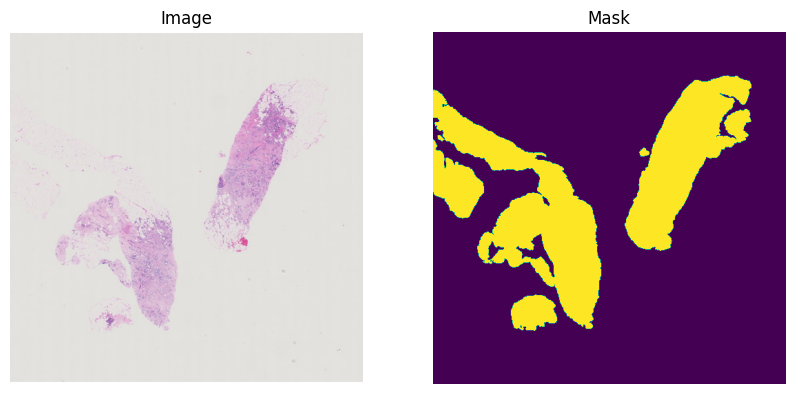

In [23]:
plot_image_mask_by_path("images/1.png", "masks/1.png")

In [24]:
metadata_df.to_csv("metadata.csv", index=False)

In [25]:
api = hfh.HfApi()

# upload zipped folder
!zip -r images.zip images
!zip -r masks.zip masks

api.upload_file(
    path_or_fileobj="images.zip",
    path_in_repo="images.zip",
    repo_id=output_repo_id,
    repo_type="dataset",
)

api.upload_file(
    path_or_fileobj="masks.zip",
    path_in_repo="masks.zip",
    repo_id=output_repo_id,
    repo_type="dataset",
)

api.upload_file(
    path_or_fileobj="metadata.csv",
    path_in_repo="metadata.csv",
    repo_id=output_repo_id,
    repo_type="dataset",
)

  adding: images/ (stored 0%)
  adding: images/24.png (deflated 2%)
  adding: images/44.png (deflated 0%)
  adding: images/17.png (deflated 1%)
  adding: images/45.png (deflated 0%)
  adding: images/53.png (deflated 2%)
  adding: images/81.png (deflated 0%)
  adding: images/54.png (deflated 1%)
  adding: images/74.png (deflated 6%)
  adding: images/8.png (deflated 0%)
  adding: images/12.png (deflated 1%)
  adding: images/97.png (deflated 4%)
  adding: images/43.png (deflated 0%)
  adding: images/37.png (deflated 0%)
  adding: images/13.png (deflated 3%)
  adding: images/91.png (deflated 1%)
  adding: images/1.png (deflated 0%)
  adding: images/34.png (deflated 0%)
  adding: images/90.png (deflated 5%)
  adding: images/9.png (deflated 0%)
  adding: images/82.png (deflated 0%)
  adding: images/69.png (deflated 4%)
  adding: images/77.png (deflated 4%)
  adding: images/73.png (deflated 0%)
  adding: images/2.png (deflated 0%)
  adding: images/15.png (deflated 5%)
  adding: images/27.png 

'https://huggingface.co/datasets/ain3007-project/test-dataset-thumbnails-512-padded/blob/main/metadata.csv'